# DATA 37000 - Final Project
## Image Classification on Open Images V4 (5 Animal Classes)

**Student:** Ubaid Jamal
**Project Type:** Image Classification (CNN)

**Classes used (Open Images V4 subset):**
- Cat  
- Dog  
- Horse  
- Bird  
- Sheep 

## 0. Setup / Imports

In [1]:
import os
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms, models

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DATA_DIR = f"..{os.sep}data{os.sep}bigdata{os.sep}open_images_5animals_300each"
print("Data directory:", DATA_DIR)
print("Classes (folders):", os.listdir(DATA_DIR))


Using device: cpu
Data directory: ..\data\bigdata\open_images_5animals_300each
Classes (folders): ['Bird', 'Cat', 'Dog', 'Horse', 'Sheep']


## 1. Problem Statement

### 1.1 Why this dataset was chosen?
For my final project, I used a subset of the **Open Images Dataset V4** which included the following five animal classes:

- **Cat**
- **Dog**
- **Horse**
- **Bird**
- **Sheep**

The rationale for choosing these classes is as follows: firstly, all these classes are visually distinct but conceptually related, i.e., they all represent common animals, secondly, each of these animals are well-represented in the data source, allowing me to download roughly **300 images per class**, and thirdly, these classes combined make for an interesting multi-classification problem that is computationally manageable for training CNNs on a single GPU/CPU.

### 1.2 Real-world relevance:
Multi-class animal recognition has several important real-world implications and applications. For example, it allows for automatic taggining of pets in an individual's personal image library. Additionally, it can help for animal recognition in farm/shelter monitoring. An added application is content-based search and filtering for common animals in large open-source image collections.

Although differentiating between commonly found animals does not offer applications as important as medical imaging or other security applications, it still entails a core challenge involved in real-world computer vision, i.e., interpreting variation in factors such as pose, background clutter, lighting, image quality, etc.

### 1.3 What the model in this project aims to achieve?

This project focuses on **supervised image classification**; thus, put simply, I aim to train a model that takes an image as the input and predicts one of five labels: **{Cat, Dog, Horse, Bird, Sheep}**. Additionally, I intend on:

1. Building a baseline CNN trained from scratch
2. Building an improved model that utilizes transfer learning or ResNet18 fine-tuning with data augmentation and a better optimization setup
3. Comparing and contrasting between the two models using commonly used classification metrics

## 2. Data Exploration (EDA)

In [2]:
eda_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(root=DATA_DIR, transform=eda_transform)
class_names = dataset.classes

print("Classes:", class_names)
print("Total images:", len(dataset))

Classes: ['Bird', 'Cat', 'Dog', 'Horse', 'Sheep']
Total images: 10408


### 2.1 Image Examples

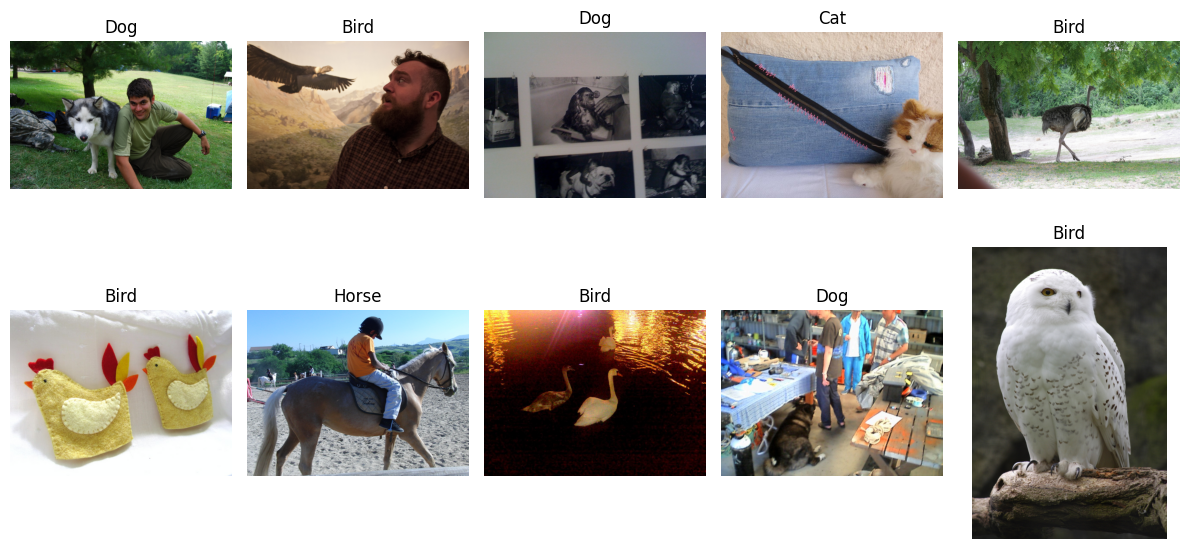

In [3]:
import random

def show_examples(dataset, class_names, n=10):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(dataset)), n)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(2, n // 2, i + 1)
        plt.imshow(img_np)
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(dataset, class_names, n=10)


### 2.2a Class Distributions


Class counts:
  Bird: 4673 images
  Cat: 1675 images
  Dog: 2475 images
  Horse: 1343 images
  Sheep: 242 images


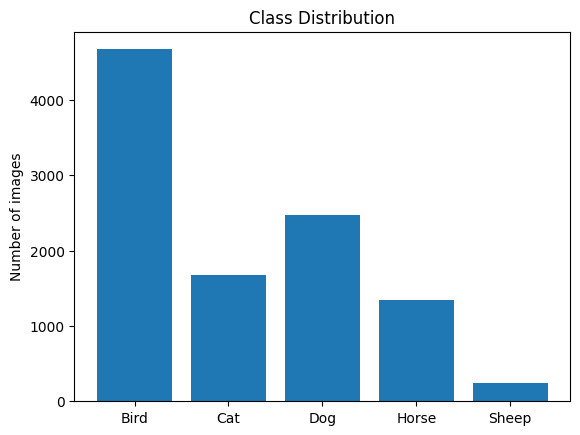

In [4]:
labels = [dataset[i][1] for i in range(len(dataset))]
counts = Counter(labels)

print("Class counts:")
for idx, name in enumerate(class_names):
    print(f"  {name}: {counts[idx]} images")

plt.figure()
plt.bar(class_names, [counts[i] for i in range(len(class_names))])
plt.title("Class Distribution")
plt.ylabel("Number of images")
plt.show()

#### 2.2.b Handling class imbalance via downsampling
As shown above, our classes are highly imbalanced, as such, we will employ downsampling for the following two reasons:

1. **Training time**: Using ~10K images for a baseline and improved model would significantly increase training time on my hardware.
2. **Class imbalance**: Some classes (e.g., Bird, Dog, Horse) have far more samples than Sheep, which could cause the model to prioritize majority classes.

To keep the dataset **balanced and computationally manageable**, I downsample each class to at most **300 images**. For classes with fewer than 300 samples (Sheep), I keep all available images.


In [5]:
MAX_PER_CLASS = 300  # keep at most 300 images per class
random.seed(42)  # for reproducibility

for cls in os.listdir(DATA_DIR):
    cls_dir = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue
    
    images = [f for f in os.listdir(cls_dir)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"{cls}: {len(images)} images before downsampling")

    # If <= 300, keep them all
    if len(images) <= MAX_PER_CLASS:
        print(f"  Keeping all {len(images)} images.")
        continue

    # Randomly select MAX_PER_CLASS images to KEEP
    keep = set(random.sample(images, MAX_PER_CLASS))

    # Delete the others
    removed = 0
    for img in images:
        if img not in keep:
            os.remove(os.path.join(cls_dir, img))
            removed += 1

    print(f"  Kept {len(keep)} images, removed {removed}.")


Bird: 4673 images before downsampling
  Kept 300 images, removed 4373.
Cat: 1675 images before downsampling
  Kept 300 images, removed 1375.
Dog: 2475 images before downsampling
  Kept 300 images, removed 2175.
Horse: 1343 images before downsampling
  Kept 300 images, removed 1043.
Sheep: 242 images before downsampling
  Keeping all 242 images.


Let's now recompute class distribution to see that our downsampling did not cause any unexpected errors.

In [6]:
# Reload the dataset after downsampling
dataset = datasets.ImageFolder(root=DATA_DIR, transform=eda_transform)
class_names = dataset.classes

labels = [dataset[i][1] for i in range(len(dataset))]
counts = Counter(labels)

print("Class counts after downsampling:")
for idx, name in enumerate(class_names):
    print(f"  {name}: {counts[idx]} images")


Class counts after downsampling:
  Bird: 300 images
  Cat: 300 images
  Dog: 300 images
  Horse: 300 images
  Sheep: 242 images


### 2.3 Image sizes & quality issues 

In [7]:
N = min(500, len(dataset))  # sample up to 500 images for speed
widths, heights = [], []

for i in range(N):
    path, _ = dataset.samples[i]
    with Image.open(path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

print(f"Checked {N} images.")
print("Min width:", min(widths), " Max width:", max(widths))
print("Min height:", min(heights), " Max height:", max(heights))
print("Avg width:", sum(widths) / len(widths))
print("Avg height:", sum(heights) / len(heights))

Checked 500 images.
Min width: 598  Max width: 4320
Min height: 527  Max height: 3240
Avg width: 978.436
Avg height: 797.652


### 2.4 Annotation format

This project uses **image-level class labels only** (no bounding boxes or segmentation masks).

### 2.5 Summary

From our EDA, we learn that our dataset has the following class sizes:

- **Bird:** 300 images  
- **Cat:** 300 images  
- **Dog:** 300 images  
- **Horse:** 300 images  
- **Sheep:** 242 images  

Thus, after downsampling, our dataset is relatively balanced, with only Sheep remaining slightly underrepresented.

Additionally, using a sample of 500 images, we learn the following about the quality of images in our dataset:

- **Min size:** 598×527 px  
- **Max size:** 4320×3240 px  
- **Average:** ~978×798 px  

This variability reflects the real-world nature of Open Images. All images will be resized to **224×224** for model training to ensure consistency across the dataset.


## 3. Constructing a baseline CNN Model

### 3.1 Transforms, dataset, train/val split, loaders

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

IMAGE_SIZE = 224
BATCH_SIZE = 32
VAL_RATIO = 0.2
RANDOM_SEED = 42

# Transforms for baseline: resize + tensor + normalize (no augmentation yet)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Full dataset with train_transform (we will reuse indices for val)
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset))

# Train/validation split
torch.manual_seed(RANDOM_SEED)
train_size = int((1 - VAL_RATIO) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Classes: ['Bird', 'Cat', 'Dog', 'Horse', 'Sheep']
Total images: 1442
Train size: 1153, Val size: 289


### 3.2 Define Simple CNN (baseline model + architecture summary)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 3x224x224 -> 16x224x224
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> 16x112x112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> 32x56x56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> 64x28x28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

baseline_model = SimpleCNN(num_classes=num_classes).to(device)
baseline_model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

### 3.3 Training setup + training loop (with logs)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def evaluate(model, loader):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

for epoch in range(num_epochs):
    baseline_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(baseline_model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")


Epoch 1/10 - Train loss: 1.6512, acc: 0.2186 - Val loss: 1.5679, acc: 0.2768
Epoch 2/10 - Train loss: 1.4790, acc: 0.3825 - Val loss: 1.4899, acc: 0.3806
Epoch 3/10 - Train loss: 1.4000, acc: 0.4068 - Val loss: 1.4539, acc: 0.3599
Epoch 4/10 - Train loss: 1.2650, acc: 0.5004 - Val loss: 1.5131, acc: 0.3287
Epoch 5/10 - Train loss: 1.0509, acc: 0.5932 - Val loss: 1.8708, acc: 0.2734
Epoch 6/10 - Train loss: 0.6901, acc: 0.7520 - Val loss: 2.0563, acc: 0.3218
Epoch 7/10 - Train loss: 0.3384, acc: 0.9020 - Val loss: 2.6540, acc: 0.2734
Epoch 8/10 - Train loss: 0.1455, acc: 0.9506 - Val loss: 3.1132, acc: 0.3114
Epoch 9/10 - Train loss: 0.1236, acc: 0.9670 - Val loss: 3.1409, acc: 0.3426
Epoch 10/10 - Train loss: 0.0745, acc: 0.9818 - Val loss: 3.8568, acc: 0.2803


### 3.4 Learning curves (loss + accuracy)

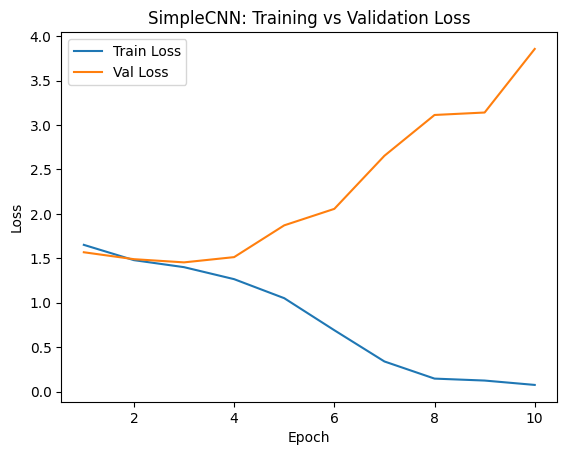

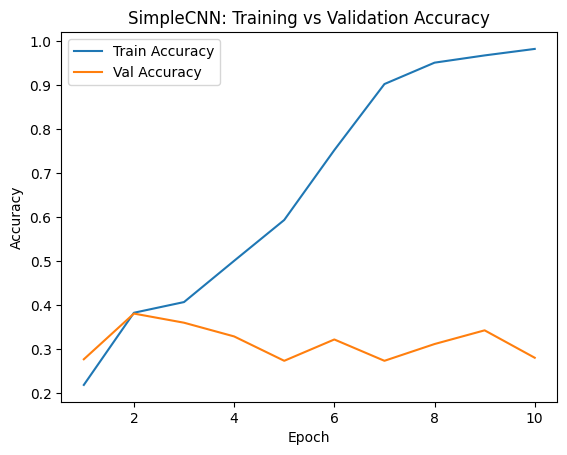

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN: Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SimpleCNN: Training vs Validation Accuracy")
plt.legend()
plt.show()

### 3.5 Evaluation Metrics

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

baseline_model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = baseline_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Overall accuracy
baseline_acc = (all_preds == all_labels).mean()
print(f"Baseline validation accuracy: {baseline_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Baseline validation accuracy: 0.2803
Confusion matrix:
 [[17 11 17  9 12]
 [ 5 17  9  8 10]
 [11 19 11 14 11]
 [15  7  9 25 15]
 [ 3  5  8 10 11]]

Classification report:
              precision    recall  f1-score   support

        Bird       0.33      0.26      0.29        66
         Cat       0.29      0.35      0.31        49
         Dog       0.20      0.17      0.18        66
       Horse       0.38      0.35      0.36        71
       Sheep       0.19      0.30      0.23        37

    accuracy                           0.28       289
   macro avg       0.28      0.28      0.28       289
weighted avg       0.29      0.28      0.28       289



### 3.6 Summary

The baseline CNN clearly overfits: training accuracy reaches ~98%, but validation accuracy stays around 28%, and validation loss increases sharply after epoch 3. This gap shows that the model memorizes the training images without learning features that generalize.

Per-class precision and recall are consistently low (0.19–0.38), and the confusion matrix shows frequent misclassification across all classes. Overall, the baseline model demonstrates poor generalization, motivating the need for a stronger architecture and better regularization.

## 4. Improved Model – ResNet18 + Data Augmentation

### 4.1 New datasets/loaders for ResNet18 (with augmentation)

In [13]:
## 4.1 Data augmentation + loaders for ResNet18

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

IMAGE_SIZE = 224
BATCH_SIZE = 32

# Base dataset (no transform here; we'll apply transforms in a wrapper)
base_dataset = datasets.ImageFolder(root=DATA_DIR)
class_names = base_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(base_dataset))

# Reuse the SAME indices as baseline split
train_indices = train_dataset.indices
val_indices = val_dataset.indices

print("Train indices:", len(train_indices))
print("Val indices:", len(val_indices))

# ResNet-style transforms
train_transform_resnet = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform_resnet = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class TransformWrapper(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base_dataset[self.indices[i]]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_dataset_resnet = TransformWrapper(base_dataset, train_indices, train_transform_resnet)
val_dataset_resnet   = TransformWrapper(base_dataset, val_indices,   val_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_resnet   = DataLoader(val_dataset_resnet,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"ResNet train size: {len(train_dataset_resnet)}, val size: {len(val_dataset_resnet)}")


Classes: ['Bird', 'Cat', 'Dog', 'Horse', 'Sheep']
Total images: 1442
Train indices: 1153
Val indices: 289
ResNet train size: 1153, val size: 289


### 4.2 Define improved model: ResNet18 (frozen) + new FC

In [14]:
from torchvision import models
import torch.nn as nn

# Load ResNet18 pretrained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all convolutional layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace final fully-connected layer
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

improved_model = resnet18.to(device)
improved_model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.3 Training loop with early stopping

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_improved = optim.Adam(improved_model.fc.parameters(), lr=1e-4)  # only train final layer

num_epochs_improved = 10
patience = 3  # early stopping patience

res_train_losses, res_val_losses = [], []
res_train_accs, res_val_accs = [], []

best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

def evaluate_resnet(model, loader):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

for epoch in range(num_epochs_improved):
    improved_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader_resnet:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_improved.zero_grad()
        outputs = improved_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_improved.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate_resnet(improved_model, val_loader_resnet)

    res_train_losses.append(train_loss)
    res_val_losses.append(val_loss)
    res_train_accs.append(train_acc)
    res_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs_improved} "
          f"- Train loss: {train_loss:.4f}, acc: {train_acc:.4f} "
          f"- Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state_dict = improved_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best weights
if best_state_dict is not None:
    improved_model.load_state_dict(best_state_dict)


Epoch 1/10 - Train loss: 1.5460, acc: 0.3322 - Val loss: 1.4771, acc: 0.3945
Epoch 2/10 - Train loss: 1.4213, acc: 0.4354 - Val loss: 1.3520, acc: 0.5052
Epoch 3/10 - Train loss: 1.3179, acc: 0.5160 - Val loss: 1.2452, acc: 0.5536
Epoch 4/10 - Train loss: 1.2238, acc: 0.6036 - Val loss: 1.1601, acc: 0.6125
Epoch 5/10 - Train loss: 1.1557, acc: 0.6262 - Val loss: 1.0935, acc: 0.6644
Epoch 6/10 - Train loss: 1.0861, acc: 0.6739 - Val loss: 0.9990, acc: 0.7232
Epoch 7/10 - Train loss: 1.0288, acc: 0.6930 - Val loss: 0.9567, acc: 0.7405
Epoch 8/10 - Train loss: 0.9861, acc: 0.7147 - Val loss: 0.9117, acc: 0.7647
Epoch 9/10 - Train loss: 0.9451, acc: 0.7363 - Val loss: 0.8827, acc: 0.7578
Epoch 10/10 - Train loss: 0.9046, acc: 0.7424 - Val loss: 0.8280, acc: 0.7958


### 4.4 Learning curves for ResNet18

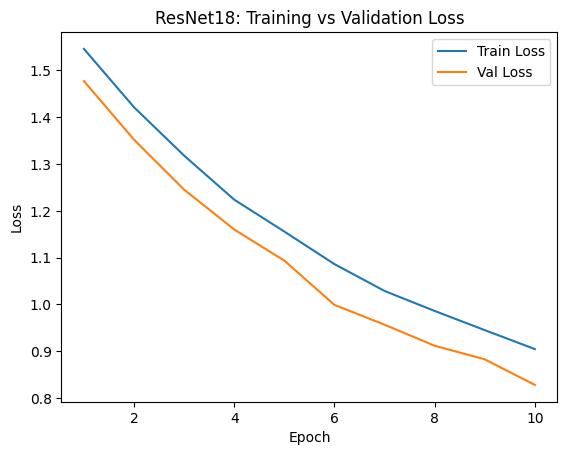

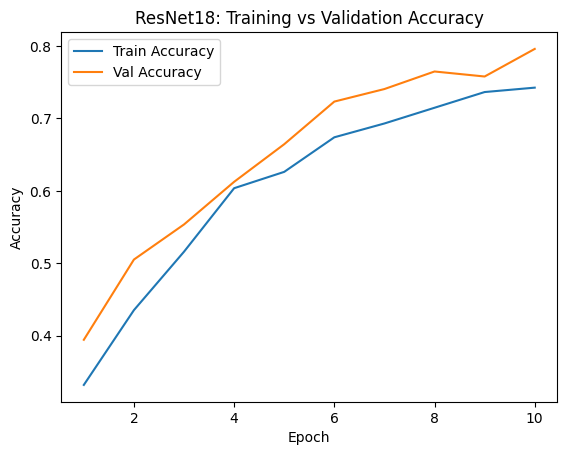

In [16]:
epochs_res = range(1, len(res_train_losses) + 1)

plt.figure()
plt.plot(epochs_res, res_train_losses, label="Train Loss")
plt.plot(epochs_res, res_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18: Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_res, res_train_accs, label="Train Accuracy")
plt.plot(epochs_res, res_val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18: Training vs Validation Accuracy")
plt.legend()
plt.show()

### 4.5 Evaluation metrics for improved model

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

improved_model.eval()
all_labels_res, all_preds_res = [], []

with torch.no_grad():
    for inputs, labels in val_loader_resnet:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = improved_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels_res.extend(labels.cpu().numpy())
        all_preds_res.extend(preds.cpu().numpy())

all_labels_res = np.array(all_labels_res)
all_preds_res = np.array(all_preds_res)

improved_acc = (all_preds_res == all_labels_res).mean()
print(f"ResNet18 improved model validation accuracy: {improved_acc:.4f}")

cm_res = confusion_matrix(all_labels_res, all_preds_res)
print("ResNet18 confusion matrix:\n", cm_res)

print("\nResNet18 classification report:")
print(classification_report(all_labels_res, all_preds_res, target_names=class_names))

ResNet18 improved model validation accuracy: 0.7958
ResNet18 confusion matrix:
 [[57  2  4  2  1]
 [ 1 42  3  3  0]
 [ 1  5 47  9  4]
 [ 5  2  6 53  5]
 [ 1  0  4  1 31]]

ResNet18 classification report:
              precision    recall  f1-score   support

        Bird       0.88      0.86      0.87        66
         Cat       0.82      0.86      0.84        49
         Dog       0.73      0.71      0.72        66
       Horse       0.78      0.75      0.76        71
       Sheep       0.76      0.84      0.79        37

    accuracy                           0.80       289
   macro avg       0.79      0.80      0.80       289
weighted avg       0.80      0.80      0.80       289



### 4.6 Summary

The fine-tuned ResNet18 shows a dramatic improvement over the baseline.
Validation accuracy increases from 28% → ~80%, and both training and validation loss decrease smoothly with no signs of divergence, indicating much better generalization.

Per-class precision and recall are strong (0.71–0.88), and the confusion matrix shows far fewer cross-class mistakes compared to the baseline. The model learns distinct features for all five animal categories, including the previously weak Sheep class.

Overall, ResNet18’s pretrained feature extractor and deeper architecture enable far richer representations than the simple CNN, leading to significantly higher accuracy, more stable training, and far better overall performance.

## 5.0 Model Evaluation and Comparison

### 5.1 Overfitting

Our baseline CNN model shows rapid overfitting: training accuracy climbs to ~98% whereas validation accuracy is a measly ~28% by epoch 10. This makes sense as we also see a steady decline in training loss but validation loss explodes after epochs ~3, 4. Such a pronounced gap between training and validation curves is reflective of strong overffiting and poor generalization.

In contrast, our improved ResNet18 model demonstrates smooth decreases in both training and validation loss; not only that but the validation accuracy also steadily climbs up to ~80%. The training and validation curves also stay close together and no late-epoch divergence is observed, indicating that our model does not strongly overfit the training data and has better generalization within the span of 10 epochs.

### 5.2 Why the improved model performs differently

Our improved model utilizes a pretrained ResNet18, which has already learned useful visual features (edges, textures, shapes) from millions of ImageNet images. Because of this, it starts with much stronger representations compared to the baseline CNN, which must learn everything from scratch using only ~1.4k training images. Moreover, normalization and light data augmentation in our improved model allows more variation to be observed and reduces overfitting. Lastly, by training only the final classification layer, we drastically reduce the number of trainable parameters; this makes optimization easier and prevents the model from memorizing the data.

Together, these improvements let ResNet18 learn generalizable patterns, while the baseline model quickly overfits and fails to generalize.

### 5.3 Baseline vs Improved CNN

Baseline CNN:
1. Val accuracy: 0.28 by epoch 10
2. Clear train–val gap; val loss increases after early epochs
3. Confusion matrix: heavy off-diagonal mass; frequent misclassification between all five classes
4. Per-class precision/recall roughly 0.19–0.38

Improved ResNet18:
1. Val accuracy: 0.80 by epoch 10
2. Train/val curves both improve steadily; no major divergence
3. Confusion matrix: strong diagonal, with most samples classified correctly in each class
4. Per-class precision/recall roughly 0.71–0.88, with all classes, including Sheep, performing well

Overall, the improved model reduces error by more than half and produces far more reliable per-class performance.

### 5.4 Classification Metrics and Curves

Accuracy:
1. Baseline: 28.0%
2. Improved ResNet18: 79.6%

Confusion matrices:
1. Baseline: scattered predictions; classes often confused with each other.
2. ResNet18: most mass along the diagonal, especially for Bird, Cat, Horse, and Sheep.

Per-class metrics:
1. Baseline: low precision/recall and F1 for all classes.
2. ResNet18: high precision and recall across the board (e.g., Bird ~0.88/0.86, Sheep ~0.76/0.84).

Train/validation curves:
1. Baseline: training loss down, validation loss up → overfitting.
2. ResNet18: both losses decrease; both accuracies increase smoothly, with validation slightly higher than training for much of training, consistent with a well-regularized transfer-learning setup.

These metrics clearly show that the improved model is substantially more accurate and better calibrated.

## 6.0 Discussion and Interpretation

### 6.1 What worked?

1. Transfer learning with ResNet18 dramatically boosted validation accuracy (~28% → ~80%).
2. Freezing the backbone and training only the final layer prevented overfitting.
3. Light augmentation helped the model generalize better.

### 6.2 What didn't work?

1. The baseline CNN severely overfit and failed to learn robust features.
2. Adding BatchNorm/Dropout did not meaningfully improve the simple CNN - code hasn't been provided here but was separately tested.
3. Early stopping did not have an impact on the imrpoved model within a short 10-epoch window.


### 6.3 Ethical Considerations

1. Open Images may contain biased or unevenly distributed examples.
2. Pretrained models inherit ImageNet biases.
3. Real-world deployment must consider licensing and misclassification risks.

### 6.4 Dataset Limitations

1. High variation in backgrounds and image quality increases difficulty. Certain pictures classified as bird, for example, vary greatly with one depicting a real bird while another depicting a drawing of a bird.
2. Class Imbalances with fewer Sheep images.
3. Some labels may be noisy or ambiguous.


### 6.5 Future improvements

1. Fine-tune more of ResNet18 (or use a stronger model).
2. Add more data for underrepresented classes.
3. Try better augmentation or hyperparameter tuning.
4. Train with a GPU to support deeper fine-tuning.